In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Choose a start date and end date for your trip
start_date = dt.datetime.strptime('2016-08-01', '%Y-%m-%d').date()
end_date = dt.datetime.strptime('2016-08-09', '%Y-%m-%d').date()

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Use inspector to get the column names of the table
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Print the column names in the 'measurement' table
columns = inspector.get_columns('measurement')
for col in columns:
    print(col['name'],col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Print the column names in the 'station' table
columns = inspector.get_columns('station')
for col in columns:
    print(col['name'],col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

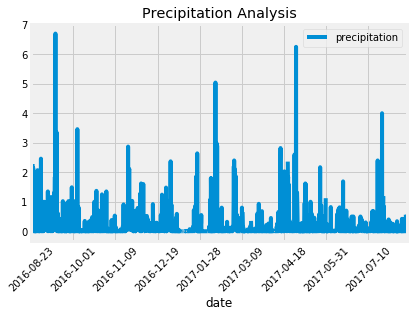

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Query the database for the last date data point
query_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Convert the date obtained from SQL query to datetime object
query_date=dt.datetime.strptime(query_date[0], '%Y-%m-%d').date()

# Calculate the date 1 year ago from the last data point in the database
year_ago = query_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=year_ago).\
    order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results,columns=['date','precipitation'])

# Sort the dataframe by date
df.set_index('date',inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=45)
plt.title("Precipitation Analysis")
plt.savefig('Images/Precipitation Analysis.png')

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
        filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

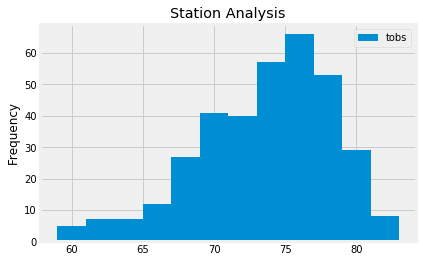

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_ago).all()

df_mostactive = pd.DataFrame(result,columns=['tobs'])
df_mostactive.plot.hist(bins=12)
plt.title("Station Analysis")
plt.savefig('Images/Station Analysis.png')

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
previous_year_startdate = start_date - dt.timedelta(days=365)
previous_year_enddate = end_date - dt.timedelta(days=365)

temp_stats= calc_temps(previous_year_startdate, previous_year_enddate)

print(f'Previous year temperature data: \n Minimum Temperature:{temp_stats[0][0]} \n Maximum Temperature: {temp_stats[0][2]} \n Average Temperature: {temp_stats[0][1]}' )

Previous year temperature data: 
 Minimum Temperature:69.0 
 Maximum Temperature: 85.0 
 Average Temperature: 78.27777777777777


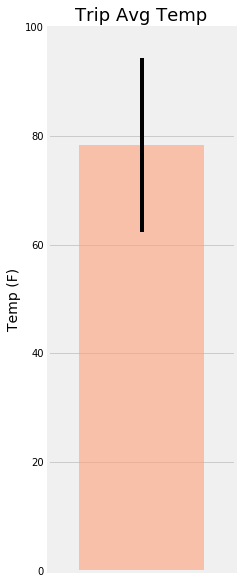

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,10))
plt.bar(0, temp_stats[0][1],  yerr=temp_stats[0][2]-temp_stats[0][0], color="lightsalmon", width=2.0, alpha=0.6)
plt.xlim((-1.5, 1.5))
plt.ylim((0, 100))
plt.xticks([])
plt.ylabel(f"Temp (F)", fontsize=14)
plt.title("Trip Avg Temp", fontsize=18)
plt.savefig('Images/Trip Avg Temp.png')

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
precipitation = session.query(Measurement.station, func.sum(Measurement.prcp),Station.name,Station.latitude,Station.longitude, Station.elevation).\
            join(Station, Measurement.station == Station.station).filter(Measurement.date >= previous_year_startdate).\
            filter(Measurement.date <= previous_year_enddate).\
            group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

print(*precipitation, sep="\n")

('USC00516128', 2.1700000000000004, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00513117', 0.91, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519281', 0.79, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00519523', 0.33999999999999997, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00519397', 0.25, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00511918', 0.1, 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
('USC00517948', 0.05, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


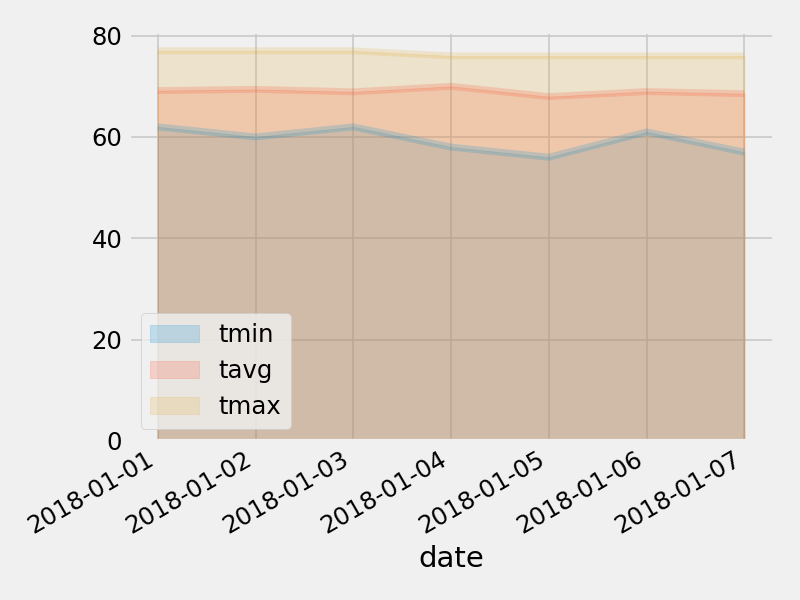

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
